In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

sns.set_style("whitegrid")
np.random.seed(8)
torch.manual_seed(8)

# Generate sine wave


In [2]:
T = 20
L = 1000
N = 100

x = np.zeros((N, L), "int64")
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype("float64")
data

array([[ 0.19866933,  0.24740396,  0.29552021, ..., -0.21381875,
        -0.16472822, -0.11522595],
       [ 0.94898462,  0.96355819,  0.97572336, ...,  0.74097261,
         0.77360936,  0.80431249],
       [ 0.47203054,  0.42737988,  0.38166099, ...,  0.78770523,
         0.75593102,  0.72226737],
       ...,
       [-0.51550137, -0.55768372, -0.59847214, ..., -0.12577619,
        -0.17520127, -0.22418844],
       [ 0.8134155 ,  0.84147098,  0.86742323, ...,  0.50942594,
         0.55179709,  0.59278903],
       [-0.05837414, -0.10819513, -0.15774569, ...,  0.34953534,
         0.30227187,  0.25425287]])

In [3]:
train_input = torch.from_numpy(data[3:, :-1])
train_target = torch.from_numpy(data[3:, 1:])
val_input = torch.from_numpy(data[:3, :-1])
val_target = torch.from_numpy(data[:3, 1:])

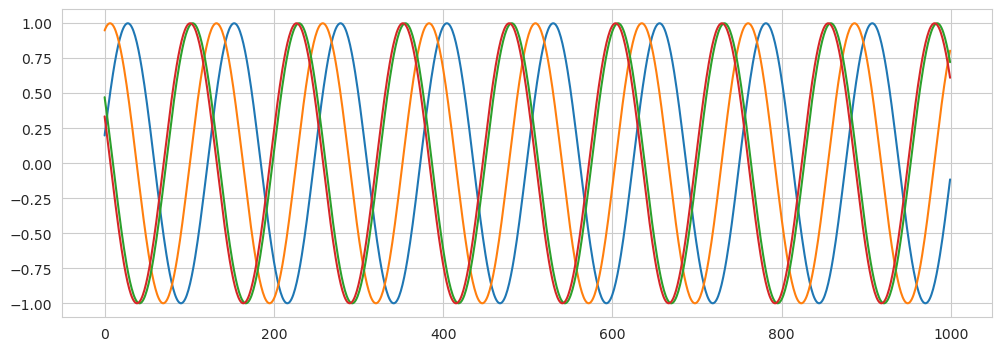

In [4]:
plt.figure(figsize=(12, 4))
for wave in data[:4, :].tolist():
    plt.plot(range(len(wave)), wave)

plt.show()

In [5]:
data.shape

(100, 1000)

Data has 100 waves, each wave consists of 1000 points.


In [6]:
train_input = torch.from_numpy(data[3:, :-1])
train_target = torch.from_numpy(data[3:, 1:])
val_input = torch.from_numpy(data[:3, :-1])
val_target = torch.from_numpy(data[:3, 1:])

We use 97 waves as training set and 3 waves as test set.


In [7]:
train_input.shape, train_target.shape

(torch.Size([97, 999]), torch.Size([97, 999]))

In [8]:
val_input.shape, val_target.shape

(torch.Size([3, 999]), torch.Size([3, 999]))

In [9]:
train_input

tensor([[ 0.3350,  0.2875,  0.2392,  ...,  0.7223,  0.6868,  0.6496],
        [ 0.1494,  0.1987,  0.2474,  ..., -0.3103, -0.2624, -0.2138],
        [ 0.9320,  0.9490,  0.9636,  ...,  0.6702,  0.7065,  0.7410],
        ...,
        [-0.5155, -0.5577, -0.5985,  ..., -0.0760, -0.1258, -0.1752],
        [ 0.8134,  0.8415,  0.8674,  ...,  0.4658,  0.5094,  0.5518],
        [-0.0584, -0.1082, -0.1577,  ...,  0.3959,  0.3495,  0.3023]],
       dtype=torch.float64)

In [10]:
train_target

tensor([[ 0.2875,  0.2392,  0.1904,  ...,  0.6868,  0.6496,  0.6108],
        [ 0.1987,  0.2474,  0.2955,  ..., -0.2624, -0.2138, -0.1647],
        [ 0.9490,  0.9636,  0.9757,  ...,  0.7065,  0.7410,  0.7736],
        ...,
        [-0.5577, -0.5985, -0.6378,  ..., -0.1258, -0.1752, -0.2242],
        [ 0.8415,  0.8674,  0.8912,  ...,  0.5094,  0.5518,  0.5928],
        [-0.1082, -0.1577, -0.2069,  ...,  0.3495,  0.3023,  0.2543]],
       dtype=torch.float64)

The input and target have the exact same shape, but the target is just the input but shifted 1 step to the left, i.e. the corresponding target of an input is just its next value.

![image](attachment/Screenshot_20240719_212944.png)


# Model Architecture


In [11]:
# specify dtype float64 because input is in this dtype
# and pytorch defaults to float32
DTYPE = torch.float64


class LSTM(nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTMCell(input_size=1, hidden_size=64, dtype=DTYPE)
        self.lstm2 = nn.LSTMCell(input_size=64, hidden_size=64, dtype=DTYPE)
        self.linear = nn.Linear(in_features=64, out_features=1, dtype=DTYPE)

    def forward(self, input, future=0):
        outputs = []
        h1 = torch.zeros(input.shape[0], 64, dtype=DTYPE)
        c1 = torch.zeros(input.shape[0], 64, dtype=DTYPE)
        h2 = torch.zeros(input.shape[0], 64, dtype=DTYPE)
        c2 = torch.zeros(input.shape[0], 64, dtype=DTYPE)

        # iterate through each value of all samples together
        for input_t in input.split(1, dim=1):
            input_t = input_t.type(DTYPE)
            h1, c1 = self.lstm1(input_t, (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
            outputs += [output]

        for i in range(future):
            h1, c1 = self.lstm1(output, (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
            outputs += [output]

        outputs = torch.cat(outputs, dim=1)
        return outputs


lstm = LSTM()
lstm

LSTM(
  (lstm1): LSTMCell(1, 64)
  (lstm2): LSTMCell(64, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

# Training


In [12]:
def create_batches(inputs, targets, batch_size):
    num_samples = inputs.size(0)

    for i in range(0, num_samples, batch_size):
        input_batch = inputs[i : i + batch_size]
        target_batch = targets[i : i + batch_size]
        yield input_batch, target_batch

Epoch 1  /10 | train RMSE =  0.02945215 | val RMSE =  0.00048344


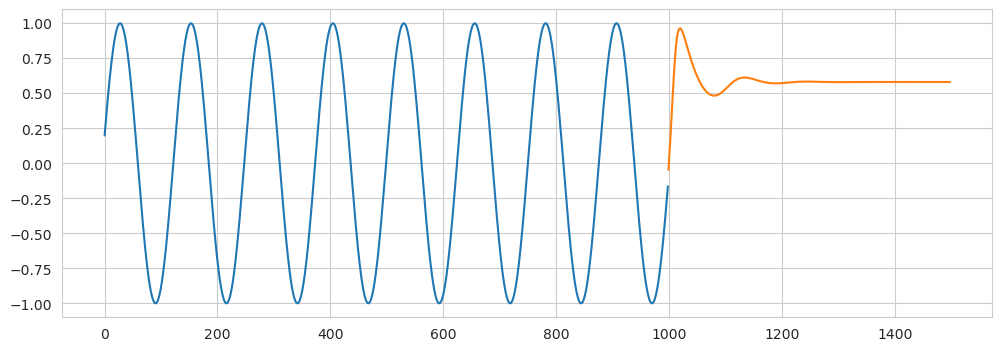

Epoch 2  /10 | train RMSE =  0.00046138 | val RMSE =  0.00033600


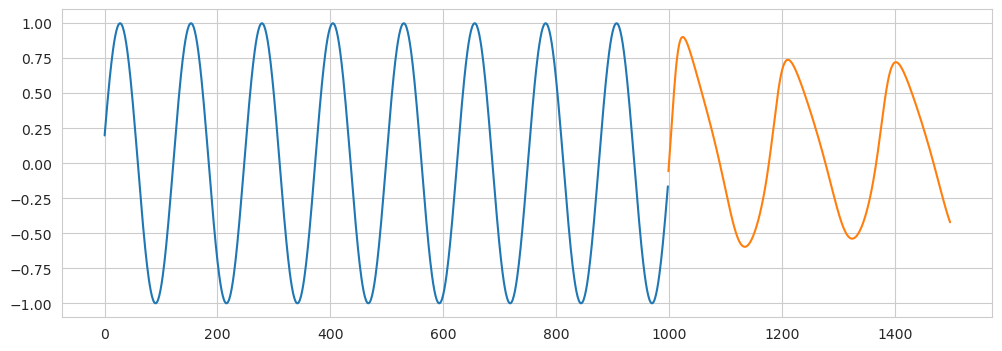

Epoch 3  /10 | train RMSE =  0.00035085 | val RMSE =  0.00025510


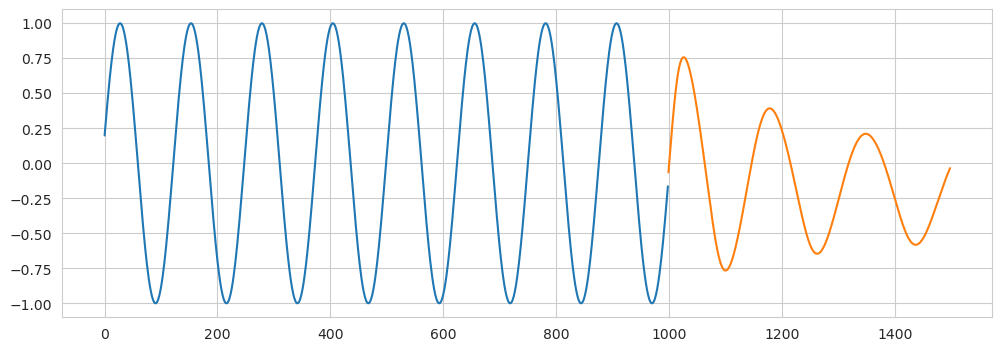

Epoch 4  /10 | train RMSE =  0.00027026 | val RMSE =  0.00019518


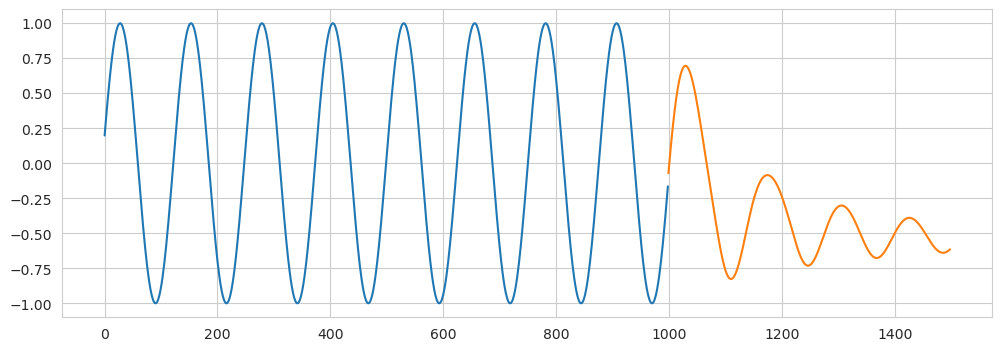

Epoch 5  /10 | train RMSE =  0.00020996 | val RMSE =  0.00015331


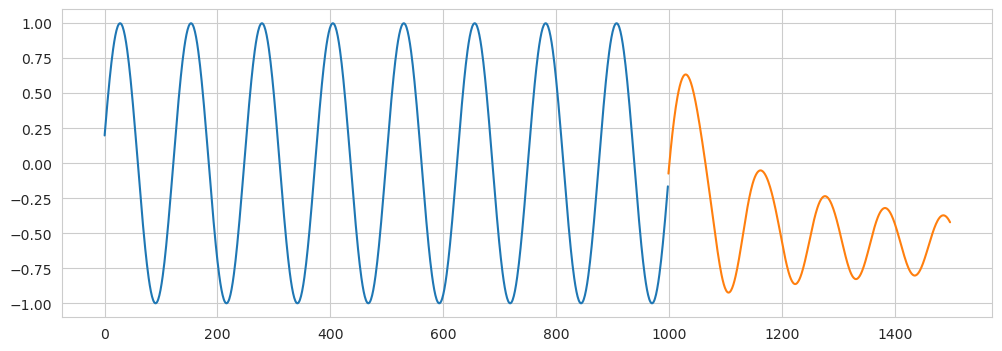

Epoch 6  /10 | train RMSE =  0.00015628 | val RMSE =  0.00010423


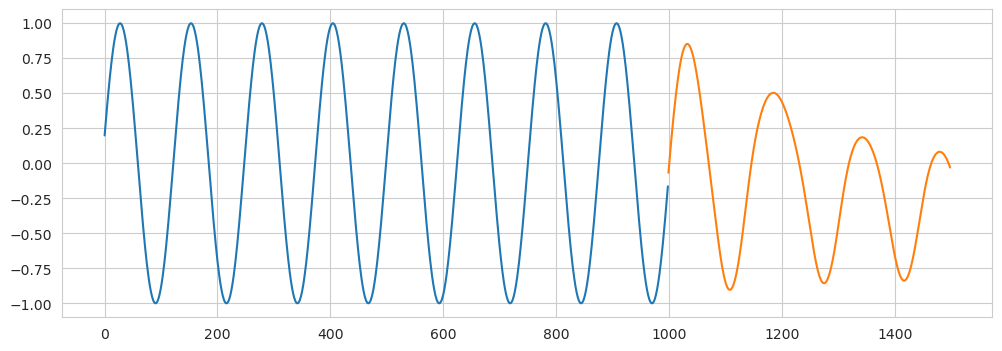

Epoch 7  /10 | train RMSE =  0.00011331 | val RMSE =  0.00006988


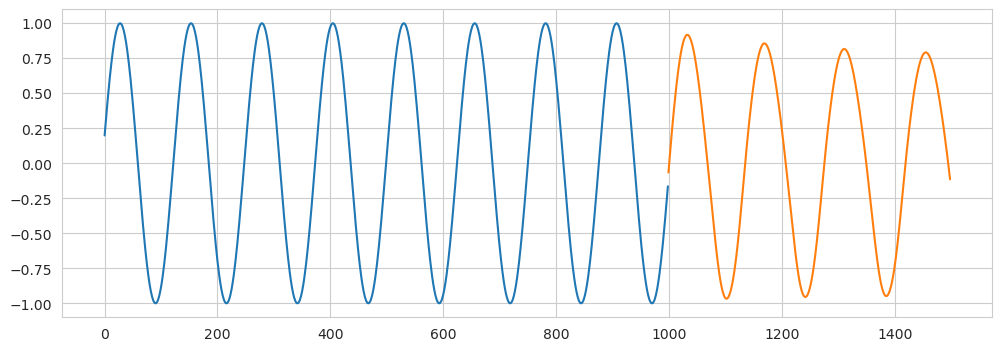

Epoch 8  /10 | train RMSE =  0.00007966 | val RMSE =  0.00005295


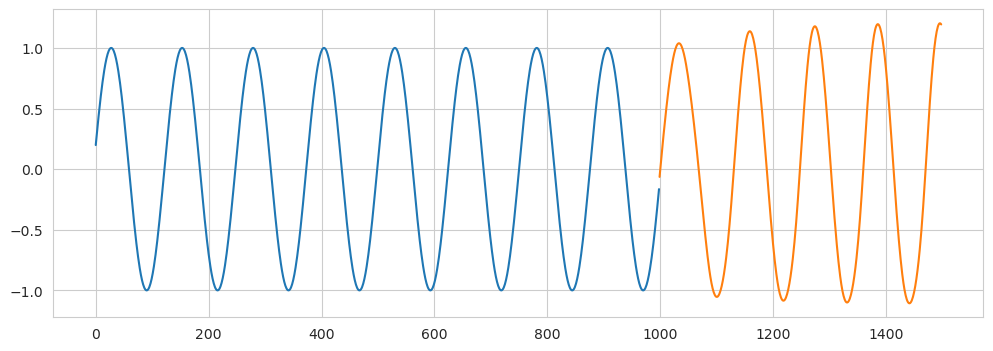

Epoch 9  /10 | train RMSE =  0.00006490 | val RMSE =  0.00003206


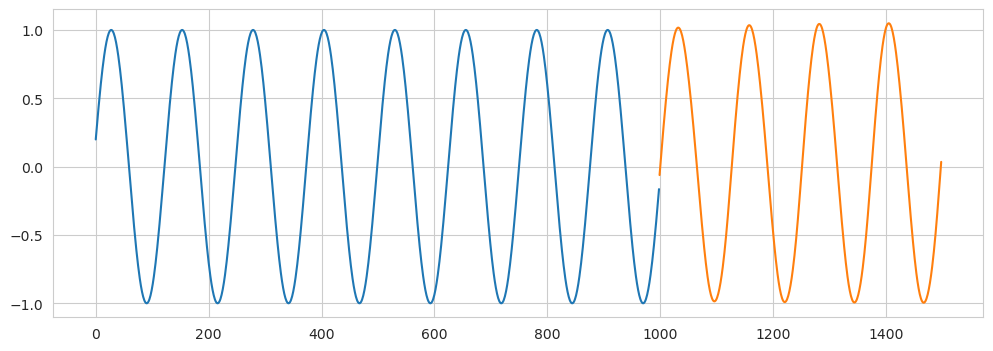

Epoch 10 /10 | train RMSE =  0.00004473 | val RMSE =  0.00002870


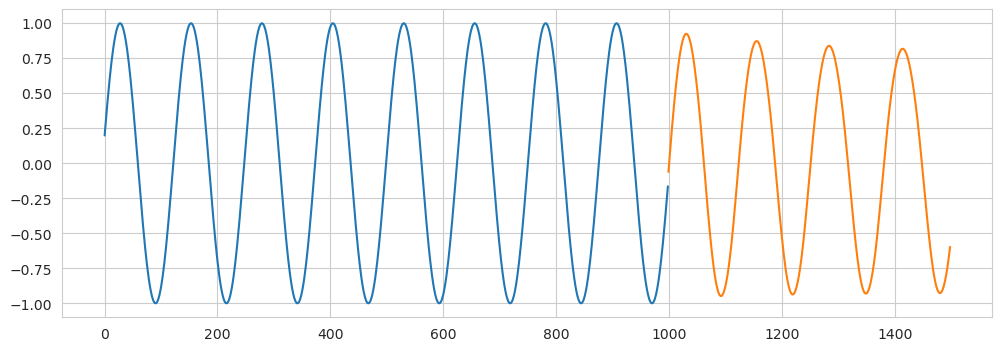

In [13]:
criterion = nn.MSELoss()
lr = 0.01
optimizer = optim.Adam(lstm.parameters(), lr=lr)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, "min")
epochs = 10
print_step = 1
batch_size = 32

for epoch in range(epochs):

    train_loss = []
    val_loss = []

    # training
    for input_batch, target_batch in zip(train_input, train_target):
        input_batch = input_batch.unsqueeze(0)
        target_batch = target_batch.unsqueeze(0)

        lstm.train()
        optimizer.zero_grad()
        outputs = lstm(input_batch)
        loss = criterion(target_batch, outputs)
        loss.backward()
        optimizer.step()
        train_loss += [loss.item()]

    # validation
    for input_batch, target_batch in zip(val_input, val_target):
        input_batch = input_batch.unsqueeze(0)
        target_batch = target_batch.unsqueeze(0)

        lstm.eval()
        with torch.no_grad():
            outputs = lstm(input_batch)
            loss = criterion(target_batch, outputs)
            val_loss += [loss.item()]

    if (epoch == 0) or ((epoch + 1) % print_step == 0):
        # print train and validation result
        avg_train_loss = np.mean(train_loss)
        avg_val_loss = np.mean(val_loss)
        print(
            f"Epoch {epoch+1: <3}/{epochs} | train RMSE = {avg_train_loss: .8f} | val RMSE = {avg_val_loss: .8f}"
        )

        # test and plot the test result
        outputs = []
        future = 500
        for input_batch, target_batch in zip(val_input, val_target):

            input_batch = input_batch.unsqueeze(0)
            target_batch = target_batch.unsqueeze(0)

            lstm.eval()
            with torch.no_grad():
                output = lstm(input_batch, future=future)
                outputs.append(output.numpy())

        outputs = np.array(outputs).squeeze()
        x_axis_actual = range(0, val_input.shape[1])
        x_axis_pred = range(val_input.shape[1], outputs.shape[1])

        plt.figure(figsize=(12, 4))
        plt.plot(x_axis_actual, val_input[0], label="Data")
        plt.plot(x_axis_pred, outputs[0, -future:], label="Forecast")
        plt.show()